In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Variables
data_path = os.path.join('..','data')
img_path = os.path.join('..','static','images')
re_link = re.compile(r"(https?:?\/\/)?(www[1-3]?.?)?((([a-zA-Z0-9\-]*)\.?)*)")

In [3]:
def unique_words(s):
    unique = set(s.split(' ')) 
    return len(unique)

def emojis(post):
    # does not include emojis made purely from symbols, only :word:
    emoji_count = 0
    words = post.split()
    for e in words:
        if 'http' not in e:
            if e.count(':')==2:
                emoji_count+=1
    return emoji_count

def colons(post):
    # Includes colons used in emojis
    colon_count = 0
    words = post.split()
    for e in words:
        if 'http' not in e:
            colon_count+=e.count(':')
    return colon_count

In [4]:
#Pull in csv
mbti_user = pd.read_csv(os.path.join(data_path,'mbti_1.csv'))

## User level data gathering

In [5]:
#Replace links with domain
mbti_user['clean_posts'] = mbti_user['posts'].str.replace(
    re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+).*"),
    lambda match: match.group(2)
    )

In [6]:
#Counting words
mbti_user['unique_words'] = mbti_user['posts'].str.replace('|||', ' ').apply(unique_words)
mbti_user['word_count'] = mbti_user['posts'].apply(lambda s : s.count(' ')+1)

In [7]:
#Counting grammer
mbti_user['qm'] = mbti_user['posts'].apply(lambda s : s.count('?'))
mbti_user['em'] = mbti_user['posts'].apply(lambda s : s.count('!'))
mbti_user['colons'] = mbti_user['posts'].apply(colons)
mbti_user['emojis'] = mbti_user['posts'].apply(emojis)

In [8]:
#Counting links
mbti_user['link_count'] = mbti_user['posts'].apply(lambda s : s.count('http'))
# mbti_user['unique_domains'] = mbti_user['posts'].replace('|||', ' ').apply(domains)
# mbti_user['unique_domains_count'] = mbti_user['unique_domains'].apply(len)
mbti_user['youtube_link'] = mbti_user['posts'].apply(lambda s : s.count('youtube') + s.count('youtu.be'))


In [9]:
#Splitting out the different personality elements
mbti_user['extroverted'] = mbti_user['type'].apply(lambda s : 1 if s[0] == 'E' else 0)
mbti_user['sensor'] = mbti_user['type'].apply(lambda s : 1 if s[1] == 'S' else 0)
mbti_user['thinker'] = mbti_user['type'].apply(lambda s : 1 if s[2] == 'T' else 0)
mbti_user['judger'] = mbti_user['type'].apply(lambda s : 1 if s[3] == 'J' else 0)

In [10]:
mbti_user.head()

,type,posts,clean_posts,unique_words,word_count,qm,em,colons,emojis,link_count,youtube_link,extroverted,sensor,thinker,judger
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'youtube,77,578,18,3,7,2,24,16,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...,77,1194,5,0,18,0,10,1,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,'Good one _____ youtube,72,869,12,4,13,0,5,3,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear INTP, I enjoyed our conversation the o...",74,1101,11,3,3,0,2,2,0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired.|||That's another silly misconce...,77,987,10,1,7,1,6,3,1,0,1,1


## Post level data gathering

In [11]:
posts = mbti_user.apply(lambda x: pd.Series(x['posts'].split('|||')), axis=1).stack().reset_index(level=1, drop=True)
posts.name = 'post'
mbti_post = mbti_user[['type']].join(posts)
mbti_post['post'] = pd.Series(mbti_post['post'], dtype=object)
mbti_post = mbti_post.reset_index().rename(columns={'index':'id'})

In [12]:
#Replace links with domains
mbti_post['clean_post'] = mbti_post['post'].str.replace(
    re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+).*"),
    lambda match: match.group(2)
    )

In [13]:
#Counting words
mbti_post['unique_words'] = mbti_post['clean_post'].apply(unique_words)
mbti_post['word_count'] = mbti_post['clean_post'].apply(lambda s : s.count(' ')+1)

In [14]:
#Counting links
mbti_post['link_count'] = mbti_post['post'].apply(lambda s : s.count('http'))
mbti_post['youtube_link'] = mbti_post['post'].apply(lambda s : s.count('youtube') + s.count('youtu.be'))

In [15]:
#Counting grammer
mbti_post['char_count'] = mbti_post['clean_post'].apply(len)
mbti_post['qm'] = mbti_post['clean_post'].apply(lambda s : s.count('?'))
mbti_post['em'] = mbti_post['clean_post'].apply(lambda s : s.count('!'))
mbti_post['colons'] = mbti_post['clean_post'].apply(colons)
mbti_post['emojis'] = mbti_post['clean_post'].apply(emojis)

In [16]:
#Splitting out the different personality elements
mbti_post['extroverted'] = mbti_post['type'].apply(lambda s : 1 if s[0] == 'E' else 0)
mbti_post['sensor'] = mbti_post['type'].apply(lambda s : 1 if s[1] == 'S' else 0)
mbti_post['thinker'] = mbti_post['type'].apply(lambda s : 1 if s[2] == 'T' else 0)
mbti_post['judger'] = mbti_post['type'].apply(lambda s : 1 if s[3] == 'J' else 0)

In [17]:
mbti_post.head()

,id,type,post,clean_post,unique_words,word_count,link_count,youtube_link,char_count,qm,em,colons,emojis,extroverted,sensor,thinker,judger
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,'youtube,1,1,1,1,8,0,0,0,0,0,0,0,1
1,0,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,1,1,1,0,1,0,0,0,0,0,0,0,1
2,0,INFJ,enfp and intj moments https://www.youtube.com...,enfp and intj moments youtube,6,6,2,2,30,0,0,0,0,0,0,0,1
3,0,INFJ,What has been the most life-changing experienc...,What has been the most life-changing experienc...,10,10,0,0,61,1,0,0,0,0,0,0,1
4,0,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,youtube,1,1,2,2,7,0,0,0,0,0,0,0,1


## Analysis

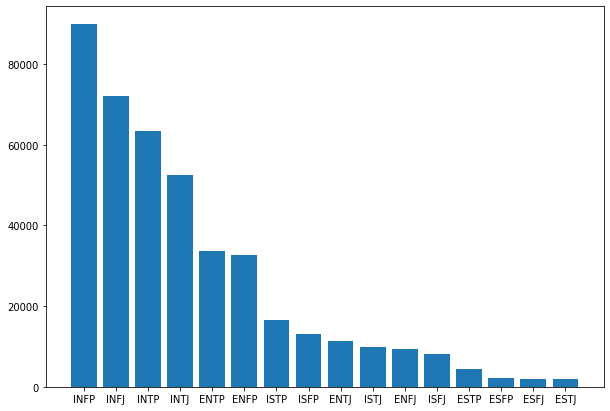

In [18]:
mb = mbti_post.groupby('type').agg({'type':'count'}).rename(columns={'type':'count'}).sort_values('count',ascending=False)
plt.figure(figsize=(10,7))
plt.bar(mb.index, mb['count'])
plt.savefig(os.path.join(img_path,"type_hist.png"))

In [39]:
mbti_post.describe()

,id,unique_words,word_count,link_count,youtube_link,char_count,qm,em,colons,emojis,extroverted,sensor,thinker,judger
count,422845.000000,422845.000000,422845.000000,422845.000000,422845.000000,422845.000000,422845.000000,422845.000000,422845.000000,422845.000000,422845.000000,422845.00000,422845.000000,422845.000000
mean,4340.423529,23.524840,26.655375,0.067793,0.043541,141.173674,0.177495,0.171183,0.251350,0.045828,0.230775,0.13722,0.457693,0.395204
std,2506.825488,11.550685,13.619516,0.290861,0.235632,70.705885,0.567216,0.767402,0.773206,0.234296,0.421329,0.34408,0.498207,0.488895
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,2165.000000,13.000000,14.000000,0.000000,0.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,4345.000000,29.000000,33.000000,0.000000,0.000000,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,6515.000000,33.000000,38.000000,0.000000,0.000000,199.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,8674.000000,44.000000,176.000000,6.000000,6.000000,263.000000,115.000000,148.000000,57.000000,27.000000,1.000000,1.00000,1.000000,1.000000


In [19]:
len(mbti_post[mbti_post['word_count']<=1])

23784

<BarContainer object of 16 artists>

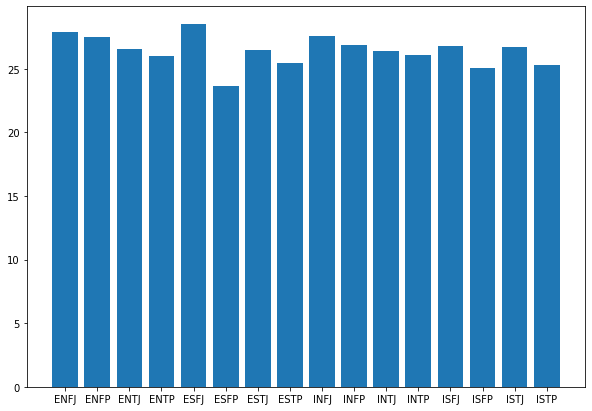

In [37]:
avg_words_type = mbti_post.groupby('type').agg({'word_count':'mean'})
plt.figure(figsize=(10,7))
plt.bar(avg_words_type.index,avg_words_type['word_count'])

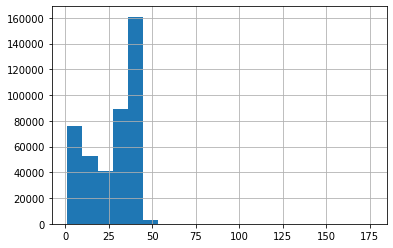

In [35]:
mbti_post['word_count'].hist(bins=20)
plt.savefig(os.path.join(img_path,"word_hist.png"))

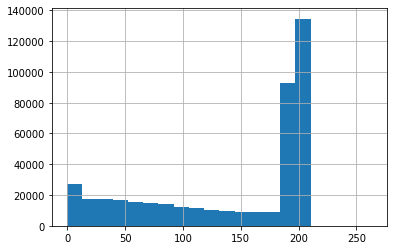

In [34]:
mbti_post['char_count'].hist(bins=20)
plt.savefig(os.path.join(img_path,"character_hist.png"))

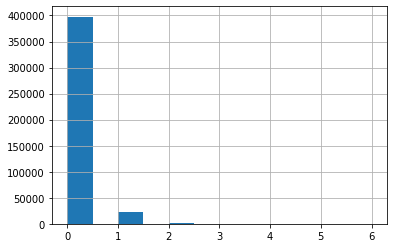

In [22]:
mbti_post['link_count'].hist(bins=12)
plt.savefig(os.path.join(img_path,"link_hist.png"))

In [23]:
unique_domains = {}
for post in mbti_post['post']:
    if 'http' in post:
        for s in post.split():
            if 'http' in s:
                s1 = s.split('.com')[0].split('//')[-1]
                s2 = s1[s1.rfind('.')+1:]
                if s2 not in unique_domains:
                    unique_domains[s2] = 1
                else:
                    unique_domains[s2] += 1
domains = pd.DataFrame(unique_domains.items(), columns=['domain', 'count']).sort_values('count', ascending=False)
len(domains)

3151

In [24]:
domains.head(10)

,domain,count
0,youtube,16708
8,jpg,1246
21,imgur,962
1,tumblr,875
22,personalitycafe,687
10,photobucket,667
66,tinypic,435
20,giphy,277
35,wordpress,244
15,blogspot,214


## Exporting final dataset to csv

In [25]:
mbti_post.to_csv(os.path.join(data_path,'mbti_phase1.csv'))